# This Notebook is my first attempt at understanding NLP and expand my knowledge. 
## Please feel free to comment for any doubts or improvement advice.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Core packages for text processing.

import string
import re

# Core packages for Training.

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer 

In [2]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")

In [3]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [4]:
print(train.shape)

(7613, 5)


In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# In order to proceed further I will perform some EDA to understand the data.

<AxesSubplot:xlabel='target', ylabel='count'>

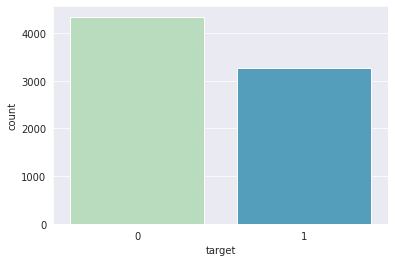

In [6]:
sns.set_style('darkgrid')
sns.countplot(x=train['target'],palette='GnBu')

The following is the meaning of the target labels:
* 0: Non Disaster
* 1: Disaster

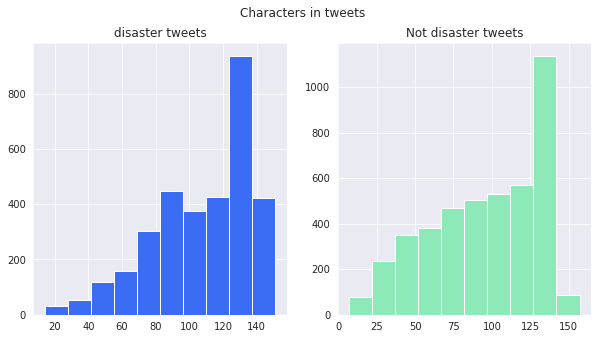

In [7]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
disaster_tweet=train[train['target']==1]['text'].str.len()
ax[0].hist(disaster_tweet,color='#3b6df4')
ax[0].set_title('disaster tweets')
notdisaster_tweet=train[train['target']==0]['text'].str.len()
ax[1].hist(notdisaster_tweet,color='#8de9b8')
ax[1].set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

In [8]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [9]:
train['location'].value_counts().head(n=20)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: location, dtype: int64

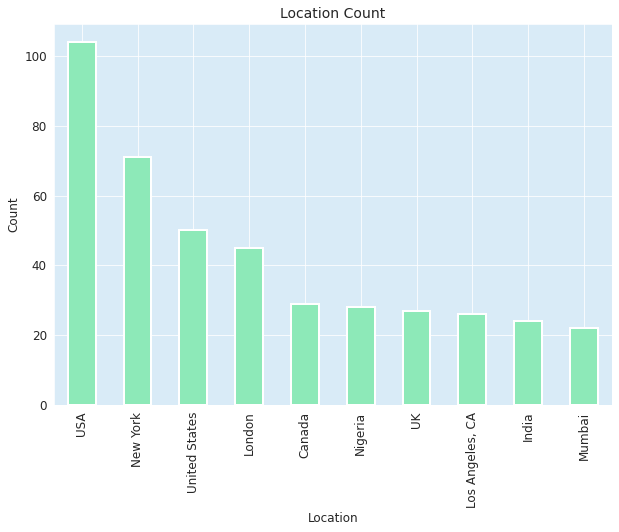

In [10]:
plt.figure(figsize = (10, 7))
ax = plt.axes()
ax.set_facecolor('#d9ebf7')
ax = ((train.location.value_counts())[:10]).plot(kind = 'bar', color = '#8de9b8', linewidth = 2)
plt.title('Location Count', fontsize = 14)
plt.xlabel('Location', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
ax.xaxis.set_tick_params(labelsize = 12, rotation = 90)
ax.yaxis.set_tick_params(labelsize = 12)

# Text Cleaning

It is a good practice to remove noise from text data for NLP. Some examples of noise can be:
* URL 
* Emoticons
* Tags
* Punctuation Marks

In [11]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions on Train Dataset

train['text_clean'] = train['text'].apply(lambda x: remove_URL(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_emoji(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_html(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_punct(x))

# Applying helper functions on Test Dataset

test['text_clean'] = test['text'].apply(lambda x: remove_URL(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_emoji(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_html(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_punct(x))

# Training LSTM Model at first

In [12]:
train

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary TheTawniest The out of control wild...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M194 0104 UTC5km S of Volcano Hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an ebike collided w...


In [13]:
test

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane My city3...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook HWO


In [14]:
df_train = train.drop(['id','keyword','location','text'],axis=1)
df_test = test.drop(['keyword','location','text'],axis=1)

In [15]:
# Move texts and targets from train & test dataset to the list:
training_message = []
testing_message = []
training_labels = []
for i in range(len(df_train)):
    training_message.append(df_train.loc[i,'text_clean'])
    training_labels.append(df_train.loc[i,'target'])
    
for i in range(len(df_test)):
    testing_message.append(df_test.loc[i,'text_clean'])

In [16]:
vocab_size = 23000
embedding_dim = 32
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [17]:
# Tokenization Process:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_message)
word_index = tokenizer.word_index

In [18]:
# texts_to_sequences Process:
training_message = tokenizer.texts_to_sequences(training_message)
testing_message = tokenizer.texts_to_sequences(testing_message)

In [19]:
#pad_sequences Process:
training_padded = pad_sequences(training_message,maxlen=max_length, truncating=trunc_type, padding=padding_type)
testing_padded = pad_sequences(testing_message,maxlen=max_length, truncating=trunc_type, padding=padding_type)

In [20]:
training_padded = np.array(training_padded)
testing_padded = np.array(testing_padded)
training_labels = np.array(training_labels)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

2022-07-27 18:30:23.289365: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           736000    
_________________________________________________________________
bidirectional (Bidirectional (None, 24)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 740,345
Trainable params: 740,345
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(
    training_padded, 
    training_labels, 
    epochs = 50, 
    batch_size = 64,  
    validation_split=0.2
)

Epoch 1/50


2022-07-27 18:30:24.024796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


96/96 [==============================] - 15s 107ms/step - loss: 0.6780 - accuracy: 0.5793 - precision: 0.5000 - recall: 7.8064e-04 - val_loss: 0.6858 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
96/96 [==============================] - 8s 88ms/step - loss: 0.6460 - accuracy: 0.5910 - precision: 1.0000 - recall: 0.0277 - val_loss: 0.6457 - val_accuracy: 0.5529 - val_precision: 1.0000 - val_recall: 0.0395
Epoch 3/50
96/96 [==============================] - 9s 89ms/step - loss: 0.5735 - accuracy: 0.7169 - precision: 0.8809 - recall: 0.3782 - val_loss: 0.5874 - val_accuracy: 0.7131 - val_precision: 0.8505 - val_recall: 0.4654
Epoch 4/50
96/96 [==============================] - 10s 99ms/step - loss: 0.5121 - accuracy: 0.7787 - precision: 0.8063 - recall: 0.6237 - val_loss: 0.5455 - val_accuracy: 0.7479 - val_precision: 0.7731 - val_recall: 0.6488
Epoch 5/50
96/96 [==============================] - 8s 85ms/step - loss: 0.4690 - accuracy: 0.8000 - pre

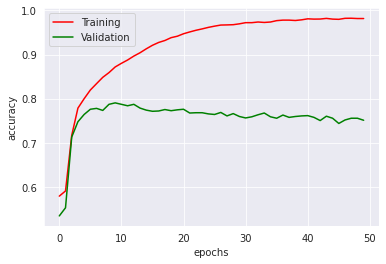

In [23]:
plt.plot(history.history["accuracy"], color="r")
plt.plot(history.history["val_accuracy"], color="g")
plt.legend(["Training", "Validation"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [24]:
test_predict = model.predict(testing_padded).round().astype(int)

# Submission

In [25]:
submission = pd.DataFrame({'id':df_test['id'],'target':test_predict.ravel()})
submission.to_csv('submission.csv',index=False)